In [1]:
import numpy as np
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import matplotlib.pyplot as plt
import h5py


## CNN APPROACH

In [2]:
sample_size = int(1e6)
n_samples = int(500)
noise_center = 0
noise_std = 5


In [3]:
training_set = np.empty((n_samples, sample_size))
true_values = np.empty(n_samples)

In [4]:
# populate arrays with noise
for i in range(n_samples):
    training_set[i,:] = np.random.normal(noise_center,noise_std,sample_size)
# add peaks at different periods
periods =  [1000,2000,5000,7000,10000]
for j in range(5):
    for i in range(n_samples//5):
        rng = np.random.RandomState(1)
        set_period = periods[j]
        x = np.arange(-100, 100)
        pos = 2000*np.exp(-0.5 * ((x+70)/12)**2)
        neg = -2000 * np.exp(-0.5 * ((x-70)/12)**2)
        event = np.zeros_like(x, dtype=float)
        # combine two gaussians
        event = pos + neg
        # create signal
        sig = 50 * rng.randn(sample_size) 
        shift0 = np.random.randint(400, set_period)
        for k in range( sample_size // set_period):
            idx = k * set_period + shift0
            if idx - 100 >= 0 and idx + 99 < sample_size:
                sig[idx - 100: idx + 100] += event
        training_set[i+j* (n_samples//5),:] += sig
        true_values[i+j* (n_samples//5)] = set_period



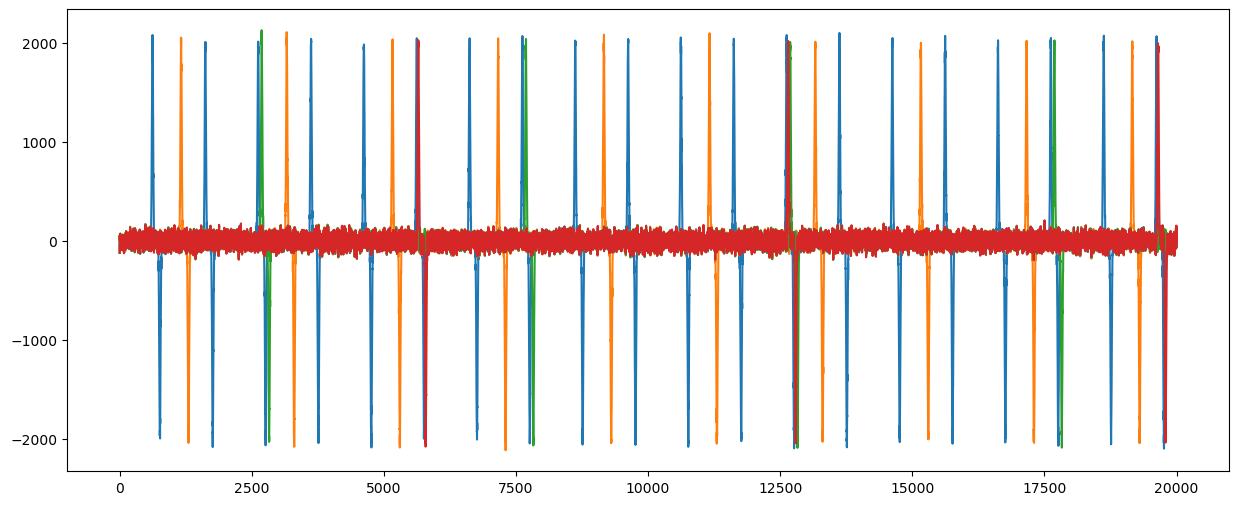

In [5]:
plt.figure(figsize=(15,6))
plt.plot(training_set[0,int(1e5):int(1e5)+20000])
plt.plot(training_set[120,int(1e5):int(1e5)+20000])
plt.plot(training_set[230,int(1e5):int(1e5)+20000])
plt.plot(training_set[340,int(1e5):int(1e5)+20000])


## USE FFT FOR FREQUENCY

In [ ]:
file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD2_20181026_131253.h5'
#file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD4_20181108_215219.h5'
#file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD4_20181108_222234.h5'


In [ ]:
with h5py.File(file, 'r') as f:
    # List all groups
    #print("Keys:", list(f.keys()))
    
    # Access a dataset
    vert_delta = f['vertical/delta'][:]   
    horiz_delta = f['horizontal/delta'][:]
    horiz_sigma = f['horizontal/sigma'][:]


In [ ]:
total_lenghth = len(vert_delta)


In [ ]:
yf = ifft(vert_delta[:int(4e5)])
xf = fftfreq(int(4e5), 1 / 4e5)[:int(2e5)]
plt.figure(figsize=(14,5))
plt.plot(xf, np.abs(yf[:int(2e5)]))


In [ ]:
plt.figure(figsize=(14,5))
plt.plot(xf[20:2000], np.abs(yf[20:2000]))

In [ ]:
max_idx = np.argmax(np.abs(yf[:int(2e5)]))
print(max_idx)

## Chat code

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from scipy.signal import find_peaks  # optional, used for nicer peak detection; not mandatory
import math

# ---------------------------
# Helper: parabolic interpolation around a discrete peak (for sub-sample refinement)
# ---------------------------
def parabolic_interpolation(y, idx):
    """
    y: 1D numpy or torch array
    idx: integer index of peak (scalar)
    returns refined_peak_pos (float, possibly fractional), peak_value (float)
    Uses three-point parabola fit around idx: (idx-1, idx, idx+1)
    """
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    n = len(y)
    if idx <= 0 or idx >= n - 1:
        return float(idx), float(y[idx])
    ym1, y0, yp1 = y[idx - 1], y[idx], y[idx + 1]
    denom = (ym1 - 2.0 * y0 + yp1)
    if denom == 0:
        return float(idx), float(y[idx])
    # vertex offset (in samples) relative to idx
    dx = 0.5 * (ym1 - yp1) / denom
    x_peak = idx + dx
    # evaluate parabola at x_peak to get peak value
    peak_val = y0 - 0.25 * (ym1 - yp1) * dx
    return float(x_peak), float(peak_val)

# ---------------------------
# Core: template-building + period estimation
# ---------------------------
def estimate_period_with_template(signal, sample_rate=1.0,
                                  min_peak_distance=2000,  # min samples between events (set < true separation)
                                  detection_prominence=None,
                                  window_halfwidth=8,
                                  max_template_examples=200,
                                  corr_search_step=1,
                                  refine_with_parabola=True):
    """
    Estimate repetition period of a sparse repeating event using template averaging + cross-correlation.

    Args:
      signal (1D numpy or torch tensor): raw 1D signal
      sample_rate (float): samples per second (if you want frequency instead of period)
      min_peak_distance (int): minimal separation between detected peaks (tune to ~half expected period)
      detection_prominence (float or None): if None, set to robust percentile-based value
      window_halfwidth (int): half-width of event window (use >=6 for ~12-sample events)
      max_template_examples (int): max number of windows to average into template
      corr_search_step (int): step size for coarse cross-correlation search (1 = full resolution)
      refine_with_parabola (bool): whether to refine correlation peak positions to sub-sample using parabola

    Returns:
      dict with keys:
        'period_samples' (float): estimated period in samples
        'period_seconds' (float or None): if sample_rate provided
        'template' (np.array): averaged template (length 2*window_halfwidth+1)
        'peak_positions' (np.array): detected event peak centers (float, possibly fractional)
        'correlation' (np.array): full correlation array (optional)
    """
    # convert to numpy for convenience
    if isinstance(signal, torch.Tensor):
        sig = signal.detach().cpu().numpy()
    else:
        sig = np.asarray(signal)
    n = len(sig)
    # 1) Rough peak detection using absolute envelope (events have big positive or negative spike)
    env = np.abs(sig)
    # set detection threshold robustly if not provided
    if detection_prominence is None:
        # use median + k * mad
        med = np.median(env)
        mad = np.median(np.abs(env - med)) + 1e-12
        detection_prominence = med + 4.0 * mad  # adjust factor as needed
    # use scipy find_peaks for convenience (or write custom)
    try:
        peaks, props = find_peaks(env, distance=min_peak_distance, prominence=detection_prominence)
    except Exception:
        # fallback: naive local maxima scanning
        peaks = []
        last_idx = -min_peak_distance
        for i in range(1, n - 1):
            if env[i] > env[i - 1] and env[i] > env[i + 1] and env[i] > detection_prominence:
                if i - last_idx >= min_peak_distance:
                    peaks.append(i)
                    last_idx = i
        peaks = np.array(peaks, dtype=int)

    if len(peaks) == 0:
        raise RuntimeError("No peaks found: try lowering detection threshold or changing min_peak_distance.")

    # 2) build template by averaging windows around detected peaks
    w = int(window_halfwidth)
    Ltpl = 2 * w + 1
    examples = []
    for p in peaks[:max_template_examples]:
        if p - w >= 0 and p + w < n:
            examples.append(sig[p - w:p + w + 1])
    if len(examples) == 0:
        raise RuntimeError("No valid windows around detected peaks (edge effects). Increase signal length or reduce window_halfwidth.")
    examples = np.stack(examples)  # (M, Ltpl)
    # optionally align polarity: if template should have + then - but some peaks might have inverted sign,
    # align each example to have same sign by forcing max(abs) to be positive orientation
    # find sign by integrated area or peak value
    peak_vals = examples[:, w]  # center sample
    signs = np.sign(peak_vals + 1e-12)
    # if center is sometimes negative, flip those to positive so averaging doesn't cancel
    for i in range(examples.shape[0]):
        if signs[i] < 0:
            examples[i] = -examples[i]
    template = np.median(examples, axis=0)  # median is robust; you could use mean

    # normalize template (zero-mean might help)
    template = template - np.mean(template)

    # 3) cross-correlate template with whole signal (normalized cross-correlation)
    # use FFT-based convolution for speed
    # normalize both template and local windows: we'll compute normalized cross-correlation approx:
    tpl = template[::-1]  # reversed for correlation as convolution
    # zero-pad lengths
    nfft = 1 << ( (n + Ltpl - 1).bit_length() )
    # FFTs
    SIG = np.fft.rfft(sig, n=nfft)
    TPL = np.fft.rfft(tpl, n=nfft)
    corr_full = np.fft.irfft(SIG * TPL, n=nfft)
    # correlation valid lags where template fully overlaps: indices [w, w+n-1] -> take first n positions starting at 0?
    corr = corr_full[:n]  # will align so that corr[k] corresponds to correlation with template centered at k
    # To get normalized cross-correlation, compute local energy via convolution of squared signal with ones window
    window = np.ones(Ltpl)
    EN_conv = np.fft.irfft(np.fft.rfft(sig * sig, n=nfft) * np.fft.rfft(window[::-1], n=nfft), n=nfft)[:n]
    tpl_energy = np.sum(tpl * tpl)
    denom = np.sqrt(np.maximum(EN_conv * tpl_energy, 1e-12))
    nxcorr = corr / denom

    # 4) find peaks in normalized cross-correlation (these correspond to event centers)
    # coarse search: pick peaks above a percentile
    thr = np.percentile(nxcorr, 99.0)  # tune percentile if needed
    candidate_idxs = np.where(nxcorr >= thr)[0]
    # cluster them so that we pick one index per event (since correlation around a true event will be a small plateau)
    if candidate_idxs.size == 0:
        # lower threshold if none are found
        thr = np.percentile(nxcorr, 95.0)
        candidate_idxs = np.where(nxcorr >= thr)[0]
    # pick local maxima among candidates
    # simple local maxima detection
    peak_positions = []
    i = 0
    while i < len(candidate_idxs):
        # group contiguous indices
        j = i
        group = [candidate_idxs[j]]
        j += 1
        while j < len(candidate_idxs) and candidate_idxs[j] == candidate_idxs[j - 1] + 1:
            group.append(candidate_idxs[j])
            j += 1
        # choose index with max nxcorr within group
        group = np.array(group)
        idx_max = group[np.argmax(nxcorr[group])]
        # optional refine with parabola
        if refine_with_parabola:
            x_refined, v = parabolic_interpolation(nxcorr, int(idx_max))
            peak_positions.append(x_refined)
        else:
            peak_positions.append(float(idx_max))
        i = j

    peak_positions = np.array(peak_positions)
    # optionally keep only well-separated ones (>= min_sep)
    if len(peak_positions) > 1:
        # sort and prune too-close detections
        peak_positions = np.sort(peak_positions)
        good = [peak_positions[0]]
        for p in peak_positions[1:]:
            if p - good[-1] >= (min_peak_distance * 0.5):  # allow half; tune as needed
                good.append(p)
        peak_positions = np.array(good)

    if len(peak_positions) < 2:
        # fallback: estimate using differences of initial rough peak detections (peaks from abs envelope)
        if len(peaks) >= 2:
            diffs = np.diff(peaks)
            period = float(np.median(diffs))
            return {
                'period_samples': period,
                'period_seconds': period / sample_rate if sample_rate is not None else None,
                'template': template,
                'peak_positions': peaks.astype(float),
                'correlation': nxcorr
            }
        else:
            raise RuntimeError("Too few detected events to estimate period. Try lowering threshold or providing hints.")

    # 5) estimate period from differences between consecutive peak_positions
    diffs = np.diff(peak_positions)
    # robust estimate: median
    period_est = float(np.median(diffs))
    # optionally remove outliers by using MAD or IQR
    # return results
    return {
        'period_samples': period_est,
        'period_seconds': period_est / sample_rate if sample_rate is not None else None,
        'template': template,
        'peak_positions': peak_positions,
        'correlation': nxcorr
    }

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # simulate a long sparse signal similar to your description for quick testing
    import matplotlib.pyplot as plt
    rng = np.random.RandomState(1)
    length = 500000
    period_true = 3000
    # build single event: positive Gaussian followed by negative Gaussian within ~12 samples
    x = np.arange(-100, 100)
    pos = 2000*np.exp(-0.5 * ((x+70)/12)**2)
    neg = -2000 * np.exp(-0.5 * ((x-70)/12)**2)
    event = np.zeros_like(x, dtype=float)
    # combine two gaussians
    event = pos + neg
    # create signal
    sig = 50 * rng.randn(length) 
    shift0 = 1200
    for k in range(10, length // period_true):
        idx = k * period_true + shift0
        if idx - 100 >= 0 and idx + 99 < length:
            sig[idx - 100: idx + 100] += event
    # show a zoom region for sanity
    plt.figure(figsize=(12,3))
    plt.plot(sig)
    plt.title("Simulated sparse repeating events")
    plt.show()

    res = estimate_period_with_template(sig, sample_rate=1.0,
                                        min_peak_distance=2000,
                                        window_halfwidth=150,
                                        detection_prominence=500)
    print("Estimated period (samples):", res['period_samples'])
    print("Detected events (first 10):", res['peak_positions'][:10])
    # show correlation around the first few events
    plt.figure(figsize=(12,3))
    plt.plot(res['correlation'][res['peak_positions'].astype(int)[0]-100: res['peak_positions'].astype(int)[0]+100])
    plt.title("Normalized correlation near first detected event")
    plt.show()


In [ ]:
res = estimate_period_with_template(vert_delta, sample_rate=1.0,
                                        min_peak_distance=9000,
                                        window_halfwidth=50,
                                        detection_prominence=None)

print("Estimated period (samples):", res['period_samples'])
print("Detected events (first 10):", res['peak_positions'][:10])
# show correlation around the first few events
plt.figure(figsize=(12,3))
plt.plot(res['correlation'][res['peak_positions'].astype(int)[0]-100: res['peak_positions'].astype(int)[0]+100])
plt.title("Normalized correlation near first detected event")
plt.show()
